In [115]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import scipy
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

In [66]:
SAMPLERATE = 8000

In [67]:

test_files_noise = os.listdir('./data/Audio/denoising/test/test/')
train_files_noise = os.listdir('./data/Audio/denoising/train/train/')
test_files_clean = os.listdir('./data/Audio/voice_origin/test/test/')
train_files_clean = os.listdir('./data/Audio/voice_origin/train/train/')

In [68]:
index=9
file_clean='./data/Audio/voice_origin/train/train/' + train_files_clean[index]
file_noise='./data/Audio/denoising/train/train/' + train_files_noise[index]
samplerate_clean, data_clean = wavfile.read(file_clean) # sample rate is the sample freqnency of the audio
samplerate_noise, data_noise = wavfile.read(file_noise)


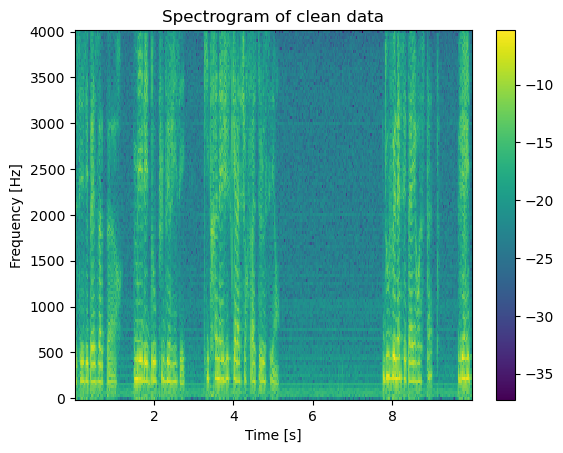

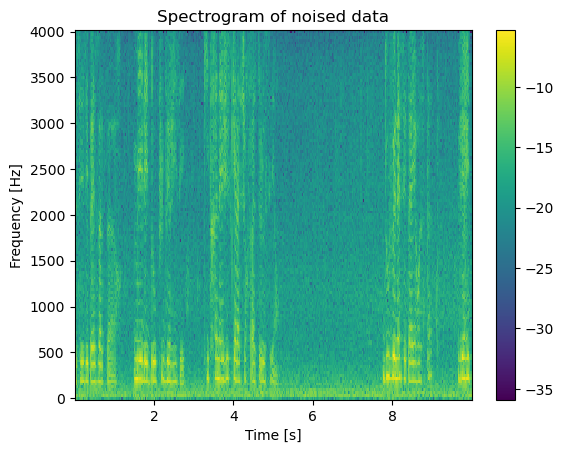

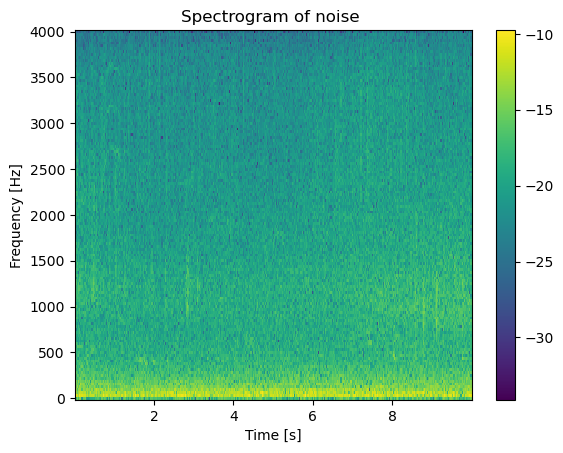

In [69]:
frequencies, times, Sxx = scipy.signal.spectrogram(data_clean/np.max(data_clean), fs=samplerate_clean)
plt.pcolormesh(times, frequencies, np.log(Sxx)) # warning logarithmic scale
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram of clean data')
plt.colorbar()
plt.show()


frequencies, times, Sxx = scipy.signal.spectrogram(data_noise/np.max(data_noise), fs=samplerate_noise)
plt.pcolormesh(times, frequencies, np.log(Sxx)) # warning logarithmic scale
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram of noised data')
plt.colorbar()
plt.show()


frequencies, times, Sxx = scipy.signal.spectrogram(data_clean/np.max(data_clean) - data_noise/np.max(data_noise), fs=samplerate_noise)
plt.pcolormesh(times, frequencies, np.log(Sxx)) # warning logarithmic scale
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram of noise ')
plt.colorbar()
plt.show()


On commence par transformer les données en spectrogrammes et les stocker dans data. 
On stocke le spectrogramme normalisé (toutes les valeurs sont entre 0 et 1). 
Ca va peut-être poser problème, à voir si on peut travailler avce les spectrogrammes normaux ou les log spectrogrammes

In [76]:

file = test_files_clean[i]
samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
frequencies, times, Sxx = scipy.signal.spectrogram(data, fs=samplerate)
pd.DataFrame(data=Sxx/np.max(Sxx)).to_csv('./data/spectrogrammes/origin/test/' + file + '.csv')
Sxx=Sxx/np.max(Sxx)

In [187]:

np.random.seed(0)
for i in tqdm.tqdm(range(len(test_files_noise))):
    file = test_files_noise[i]
    samplerate, data = wavfile.read('./data/Audio/denoising/test/test/' + file)
    frequencies, times, Sxx = scipy.signal.spectrogram(data, fs=samplerate)
    pd.DataFrame(data=Sxx/np.max(Sxx)).to_csv('./data/spectrogrammes/test/noisy/' + file + '.csv')

for i in tqdm.tqdm(range(len(test_files_clean))):
    file = test_files_noise[i]
    samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
    frequencies, times, Sxx = scipy.signal.spectrogram(data, fs=samplerate)
    pd.DataFrame(data=Sxx/np.max(Sxx)).to_csv('./data/spectrogrammes/test/origin/' + file + '.csv')
    
for i in tqdm.tqdm(range(len(train_files_noise))):
    file = train_files_noise[i]
    samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
    samplerate_clean, data_clean=wavfile.read('./data/Audio/voice_origin/train/train/' + file)
    frequencies, times, Sxx = scipy.signal.spectrogram(data, fs=samplerate)
    frequencies_clean, times_clean, Sxx_clean = scipy.signal.spectrogram(data_clean, fs=samplerate_clean)
    if np.random.random()>0.8:
        pd.DataFrame(data=Sxx/np.max(Sxx)).to_csv('./data/spectrogrammes/validation/noisy/' + file + '.csv')
        pd.DataFrame(data=Sxx_clean/np.max(Sxx_clean)).to_csv('./data/spectrogrammes/validation/origin/' + file + '.csv')
    else : 
        pd.DataFrame(data=Sxx/np.max(Sxx)).to_csv('./data/spectrogrammes/train/noisy/' + file + '.csv')
        pd.DataFrame(data=Sxx_clean/np.max(Sxx_clean)).to_csv('./data/spectrogrammes/train/origin/' + file + '.csv')


  0%|          | 0/782 [00:00<?, ?it/s]

100%|██████████| 2118/2118 [08:35<00:00,  4.11it/s]


In [188]:
nois=os.listdir('data/spectrogrammes/train/noisy/')  
orig=os.listdir('data/spectrogrammes/train/origin/')
for elt in nois : 
    if elt not in orig : 
        print(elt)
nois=os.listdir('data/spectrogrammes/validation/noisy/')  
orig=os.listdir('data/spectrogrammes/validation/origin/')
for elt in nois : 
    if elt not in orig : 
        print(elt)
nois=os.listdir('data/spectrogrammes/test/noisy/')  
orig=os.listdir('data/spectrogrammes/test/origin/')
for elt in nois : 
    if elt not in orig : 
        print(elt)

In [202]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.X = os.listdir(path_to_data + 'noisy/')
        self.Y = os.listdir(path_to_data + 'origin/')

    def __len__(self):
        assert len(self.X) == len(self.Y)
        return len(self.X)

    def __getitem__(self, idx):
        noised = np.array([pd.read_csv(self.path_to_data + 'noisy/' + self.X[idx]).drop(columns='Unnamed: 0')])
        origin = np.array( [pd.read_csv(self.path_to_data + 'origin/' + self.Y[idx]).drop(columns='Unnamed: 0')])
        return torch.tensor(noised), torch.tensor(origin) # 1, 129, 357 chacuns 

In [204]:
dataloader_test = DataLoader(Mydataset('./data/spectrogrammes/test/'), batch_size=10 , shuffle=True)
dataloader_train = DataLoader(Mydataset('./data/spectrogrammes/train/'), batch_size=10 , shuffle=True)
dataloader_validation = DataLoader(Mydataset('./data/spectrogrammes/validation/'), batch_size=10 , shuffle=True)

for batch in dataloader_test :
  print(batch[0].shape, batch[1].shape)
  break
print("il n'y a qu'un canal au début")

torch.Size([10, 1, 129, 357]) torch.Size([10, 1, 129, 357])
il n'y a qu'un canal au début


Dummy model as a baseline 

In [205]:
class Dummy (nn.Module):
  def __init__(self): # simple modèle de convolution avec 2 couches
    super(Dummy, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(11, 11), stride=2, padding = 'valid') # stride = nombre de pixels que l'on saute
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(8, 8),stride=2)
    self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(8, 8),stride=2)
    self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(11, 11), stride=2)
    

  def forward(self, x): # x = [10, 1, 129, 357]
    x = F.relu(self.conv1(x)) # [10, 16, 60, 174]
    x = F.relu(self.conv2(x)) # [10, 32, 27, 84]
    x = F.relu(self.deconv1(x)) #[10, 16, 60, 174]
    x = F.relu(self.deconv2(x)) # [10, 1, 129, 357]
    return x



In [206]:
for batch_x, batch_y in dataloader_test : 
    print(batch_x.shape, batch_y.shape)
    break

torch.Size([10, 1, 129, 357]) torch.Size([10, 1, 129, 357])


In [207]:
chemin_vers_sauvegarde_model ='./dummy_model.pth'

In [ ]:
# set train_dummy to True to train the model
train_dummy = True
device = 'cpu'
model = Dummy()
n_epochs=200
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
loss_train=[]
loss_val=[]
if train_dummy:
    for epoch in (range(n_epochs)):
        print(epoch)
        losstrain=0
        counttrain=0
        lossval=0
        countval=0
        for batch_x,batch_y in dataloader_train:
            counttrain+=1
            batch_x.to(device)
            batch_y = batch_y.long()
            batch_y.to(device)
            optimizer.zero_grad()
            mask_predicted = model(batch_x.float())
            batch_y_predicted = batch_x * mask_predicted
            l = loss(batch_y_predicted, batch_y)
            l.backward()
            losstrain+=l
            optimizer.step()
        for batch_x,batch_y in dataloader_validation:
            countval+=1
            batch_x.to(device)
            batch_y.to(device)
            with torch.no_grad():
                batch_y_predicted = model(batch_x)
                l = loss(batch_y_predicted, batch_y.long())
                lossval+=l
        if epoch%10==0:
            print(f'epoch {epoch}, training loss = {losstrain/counttrain}')
        loss_train.append(losstrain/counttrain)
        loss_val.append(lossval/countval)
        
    torch.save(model, chemin_vers_sauvegarde_model)


    # saving the losses in txt files : 
    loss_list_val=[loss_val[i].detach().numpy() for i in range(len(loss_val))]
    loss_list_train=[loss_train[i].detach().numpy() for i in range(len(loss_train))]

    with open('./loss_val_dummy.txt', 'w') as f : 
        for elt in loss_list_val : 
            f.write(str(elt) + '\n')

    with open('./loss_train_dummy.txt', 'w') as f : 
        for elt in loss_list_train : 
            f.write(str(elt) + '\n')

0


KeyboardInterrupt: 